# Phragmites Classification: Full Image Classification

This notebook represents a beta application for the segmentation of the plant Phragmites in satelite images.
<br>

Built by Troy Saltiel and Greg Lee

Last modified: 04.15.20

In [31]:
#Libraries: 
import os
import numpy as np
import functions #Custom Library built for Phragmites Classification

import matplotlib.pyplot as plt
import rasterio as rio
import earthpy.plot as ep

import sklearn as sk
from sklearn.metrics import accuracy_score
import tensorflow as tf

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.titlesize'] = 20

# Project Overview

An invasive subspecies of Phragmites australis was likely introduced to Utah in the early 1980s, and, as an aggressive invader, has been a nuisance ever since. The plant tends to form monotypic stands that are not suitable habitats for the many migratory birds that rely on the native ecosystem. The spread of Phragmites can also decrease diversity, alter nutrient cycling and hydrology, and increase fire danger. The Utah Department of Natural Resources (DNR) has been working to remove the plant for many years, and in an effort to keep track of progress and evaluate the effectiveness of remediation, the DNR is imaging the Howard Slough Waterfowl Management Area as they apply a pesticide. The environment is extremely difficult to navigate and requires a Marsh Master (essentially a tank) to avoid vehicles sinking into the marsh. A small Unmanned Aerial System (sUAS) is ideal for monitoring the situation. The sUAS is fitted with a multispectral image sensor (blue, green, red, red-edge, and near-infrared bands) and flown at a height to produce a ground sample distance of about 7.5 cm.

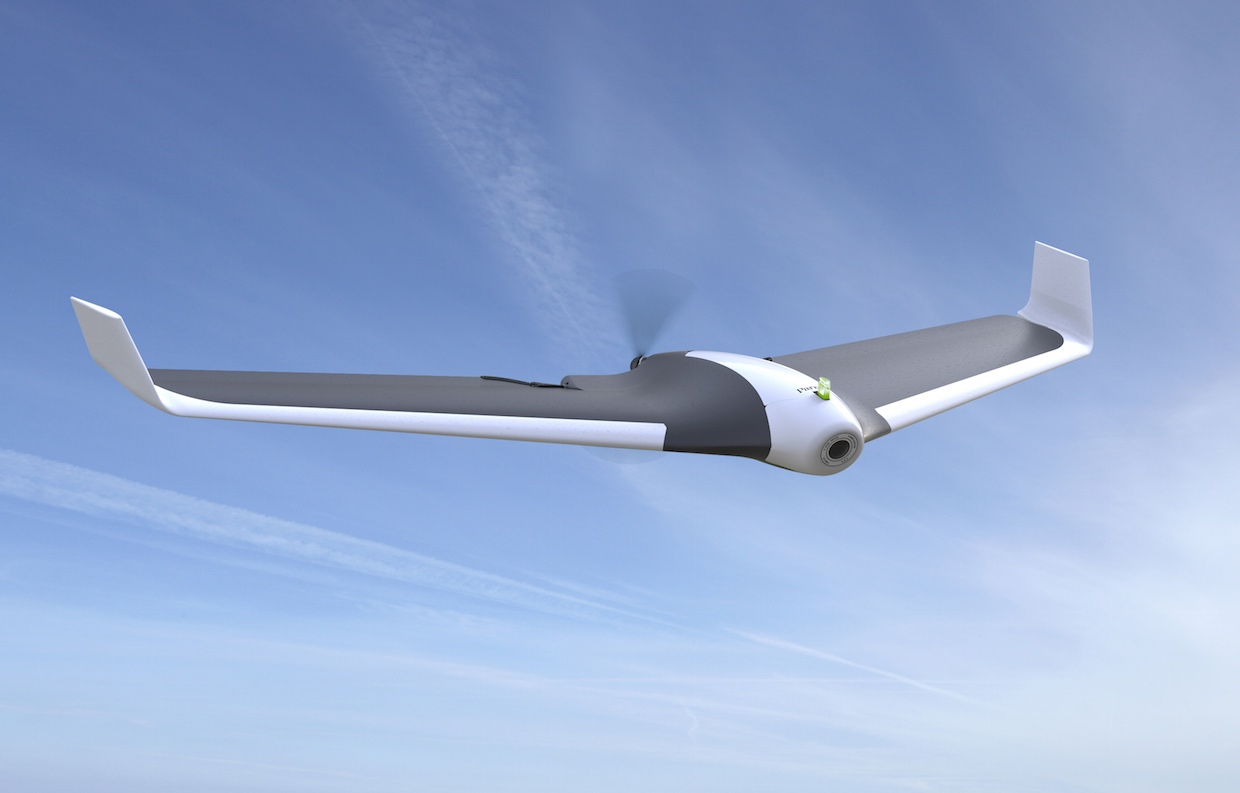

In [4]:
from IPython.display import Image
Image("parrot.jpeg")

The small Unmanned Aerial System (sUAS) used to capture the imagery. Parrot DISCO.

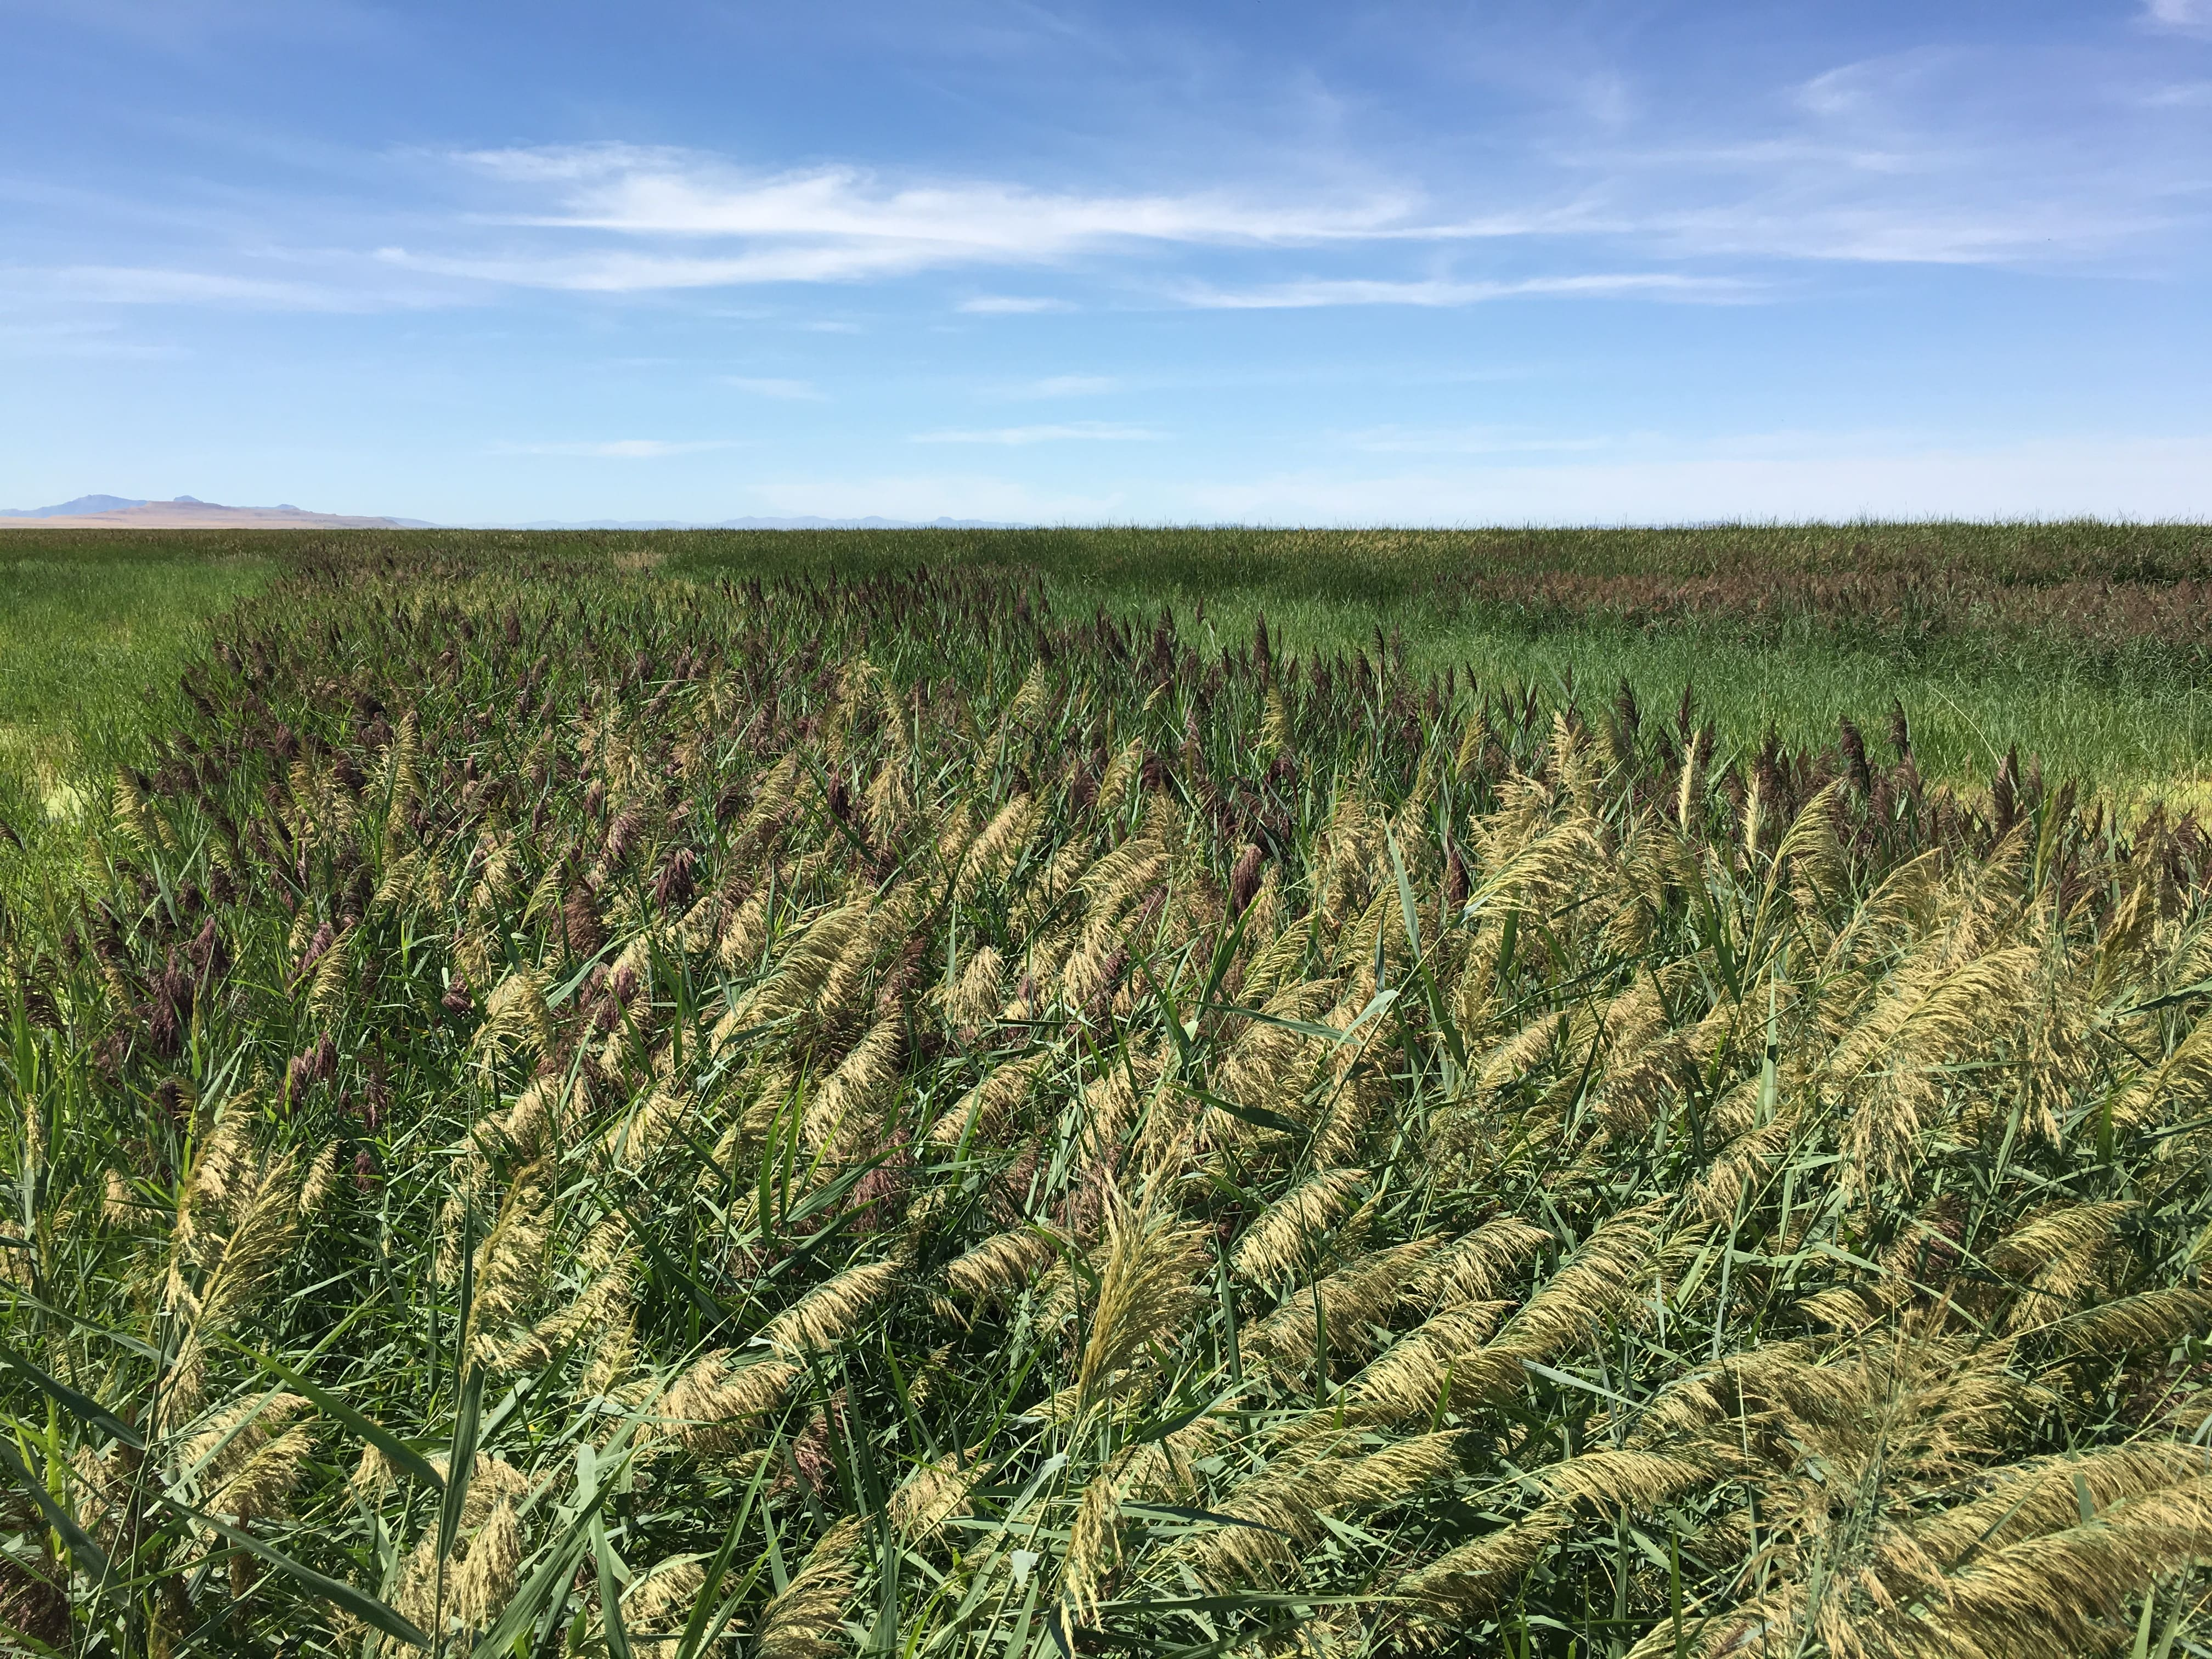

In [2]:
Image("phrag.jpg")

Pictured: Phragmites in the study area.

**The primary objective is to produce classified maps of Phragmites with reasonable accuracy.**

The data is a 4775 x 15282 x 5 image in the TIFF file format. Due to limits in training data and time, the image was cropped to 630 x 6792 x 5, and split by 0.5 for train and test sets. 

The training data were office-interpreted, and geotagged photographs were utilized as a visual aid. In remote sensing, we do not have the luxury of perfect training data, and especially in this case, it is near impossible to collect due to the environment. Office interpretation is standard practice, and as a result, remote sensing is often considered a science and an art. Troy’s interpretation of the image is aided by his on the ground experience (and the photos), and the help of an ecologist from the DNR. 

We utilized the Geographic Information System software, ArcGIS Pro (Esri), to label the training data. A portion of the image, about 5%, was selected for its diverse representation of each class. To label the data, a segmentation tool was run on the dataset, and segments were selected that represented each class. The tool includes parameters for spatial and spectral detail, and these were selected to ensure similar classes, i.e. vegetation species, were separate in the segmentation. In the case the segments were not representative of a class, polygons were hand-drawn. These segments and polygons were then exported using the Export Training Data for Deep Learning tool, as 32x32x6 arrays in the R-CNN mask format. This resulted in about 3,350 images and label masks.

## Load Images

In [2]:
directory = './images/'

#Copy the image paths
image_path = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    image_path.append(directory + filename)

#Sort the Files
image_path = sorted(image_path)

In [17]:
#Load the images
test_im = functions.open_image(image_path[0])
train_im = functions.open_image(image_path[1])

#Prepare them
test_im = functions.image_prep(test_im)
train_im = functions.image_prep(train_im)

print('The shape of the training file: {0}'.format(train_im.shape))
print('The shape of the testing file: {0}'.format(test_im.shape))

The shape of the training file: (2130, 32, 32, 5)
The shape of the testing file: (2130, 32, 32, 5)


## Rebuild the Model

In [24]:
# Recreate the UNet model, including its weights and the optimizer
model = tf.keras.models.load_model('v1_unet_full_model.h5')

In [25]:
#Visualizing predictions: 
test_pred = model.predict(test_im, verbose=1)
train_pred = model.predict(train_im, verbose=1)

# Need binary mask: 
test_pred = (test_pred > 0.5).astype(np.uint16)
train_pred = (train_pred > 0.5).astype(np.uint16)

2130/2130 [==============================] - 0s 115us/sample


## Visualize the Result

In [26]:
#Grab the ground truth: 
with rio.open('train_set_labels_raster.tif', 'r+') as src:
    train_label = src.read()

with rio.open('test_set_labels_raster.tif', 'r+') as src:
    test_label = src.read()

In [27]:
#Reshape the outputs of the network:
test_pred = functions.reshaper(functions.unstack(test_pred))
test_label = functions.reshaper(test_label)
x = int(test_label.shape[0])
y = int(test_label.shape[1])
test_pred = test_pred[:x,:y]

train_pred = functions.reshaper(functions.unstack(train_pred))
train_label = functions.reshaper(train_label)
x = int(train_label.shape[0])
y = int(train_label.shape[1])
train_pred = train_pred[:x,:y]

Accuracy: 0.8954806418371853


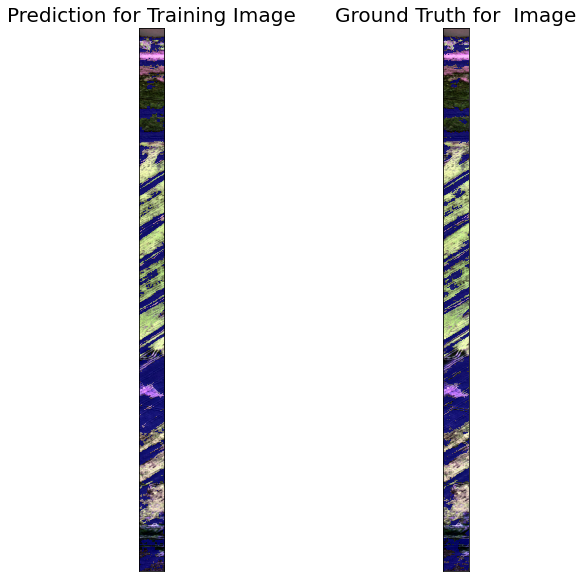

In [29]:
f, (ax1,ax2) = plt.subplots(1, 2)

#Plot the image
ep.plot_rgb(functions.open_image(image_path[1]),ax = ax1,stretch = True,rgb=[0,1,2])
#Plot the Mask
ax1.imshow(train_pred, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Prediction for Training Image')

#Plot the image
ep.plot_rgb(functions.open_image(image_path[1]),ax = ax2,stretch = True,rgb=[0,1,2])
#Plot the Mask
ax2.imshow(train_label, 'jet', interpolation='none', alpha=0.7)
ax2.set_title('Ground Truth for  Image')

print('Accuracy: {0}'.format(1- accuracy_score(train_label,train_pred)))
plt.show()

Accuracy: 0.8586572438162544


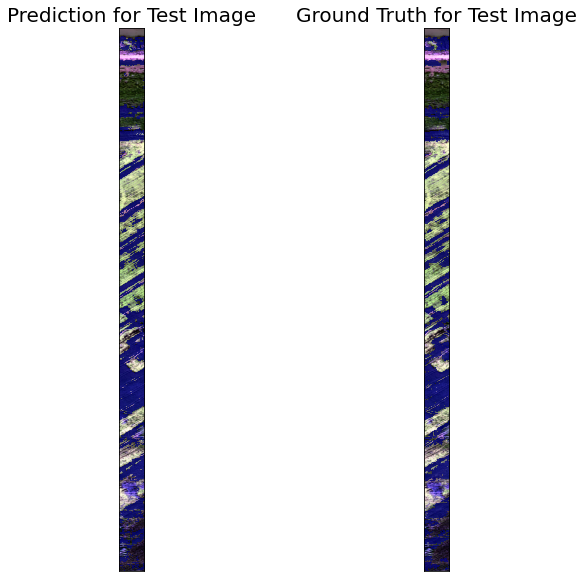

In [30]:
f, (ax1,ax2) = plt.subplots(1, 2)

#Predictions
ep.plot_rgb(functions.open_image(image_path[0]),ax = ax1,stretch = True,rgb=[0,1,2])
ax1.imshow(test_pred, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Prediction for Test Image')

#Ground Truth
ep.plot_rgb(functions.open_image(image_path[0]),ax = ax2,stretch = True,rgb=[0,1,2])
ax2.imshow(test_label, 'jet', interpolation='none', alpha=0.7)
ax2.set_title('Ground Truth for Test Image')

print('Accuracy: {0}'.format(1- accuracy_score(test_label,test_pred)))
plt.show()

# Limitations

# Ethical Considerations

The project was requested by a state government agency, and while it does involve imagery collected by a “drone”, the field site is very isolated and not near any private property. Phragmites australis is a well-known nuisance, and the primary stakeholders are the state government and duck/game hunters. Both are in support of removing the plant from the ecosystem, to improve the environment for the many birds that depend on the greater Great Salt Lake ecosystem. The largest consideration is that the DNR receives accurately classified maps, however this class project is not intended to produce any deliverable product.